# Load the data

In [1]:
!pip install pandas seaborn matplotlib numpy xgboost --quiet

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/Users/ltsai/Documents/workspace/github/datascience-examples/creditcard.csv')

In [4]:
features = df.columns.values

# Finding features with the highest correlation

In [5]:
def most_corr(param, n):
    class_corr = df.corr()[param].sort_values(ascending=False)
    list_class = []
    for i in features:
        if(np.abs(class_corr[i]) >= n): 
           list_class.append(i)
    return list_class
# Select features with correlation higher than 0.1 (positive correlation) or lower than -0.1 (negative correlation)
selected_features = most_corr('Class', 0.1)
selected_features

['V1',
 'V3',
 'V4',
 'V7',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'Class']

In [6]:
dataset = df[selected_features]

# Building your first baseline Logistic Regression model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import classification_report, recall_score, precision_score, \
    average_precision_score, plot_precision_recall_curve, f1_score, auc, \
    roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_recall_curve

In [8]:
RANDOM_SEED = 42

In [9]:
TEST_SIZE = 0.3

## Split the data into X and y

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Class',1) , dataset['Class'], test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [11]:
X_train.shape

(199364, 11)

In [12]:
X_test.shape

(85443, 11)

In [13]:
# test_size
round(X_test.shape[0]/df.shape[0], 2)

0.3

In [14]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

import xgboost as xgb

resampling = SMOTE(random_state=RANDOM_SEED)

baseline = xgb.XGBClassifier()

#SMOTE oversampling resu;ts in lower AUC and F1 scores.
#baseline = Pipeline([('SMOTE', resampling), ('XGBClassifier', baseline)])

baseline.fit(X_train, y_train)

# Obtain model predictions
y_baseline = baseline.predict(X_test)

# Probabilities 
y_proba_baseline = baseline.predict_proba(X_test)[:,1]
average_precision = average_precision_score(y_test, y_proba_baseline)

In [15]:
print(classification_report(y_test, y_baseline))
print('\n')
print('AUC: {}%'.format(roc_auc_score(y_test, y_proba_baseline)))
print('Precision-Recall: {}'.format(average_precision))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.84      0.89       136

    accuracy                           1.00     85443
   macro avg       0.98      0.92      0.95     85443
weighted avg       1.00      1.00      1.00     85443



AUC: 0.9794734019482575%
Precision-Recall: 0.8810865801736664


## AUC - ROC Curve

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

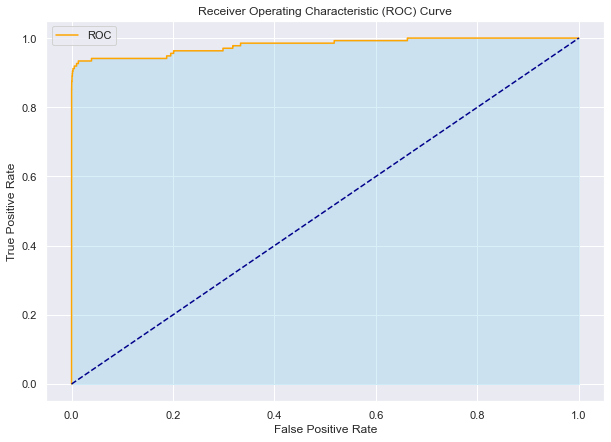

In [17]:
plt.figure(figsize = (10,7))
fpr, tpr, thresholds = roc_curve(y_test, y_proba_baseline)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.fill_between(fpr, tpr, color='skyblue', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Plot the Precision-Recall curve

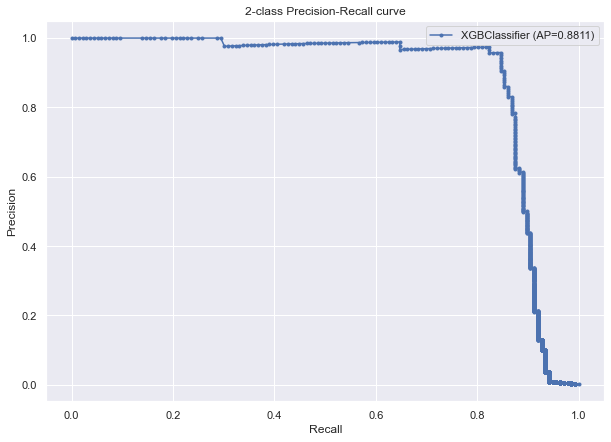

In [18]:
# For unbalanced data
plt.figure(figsize = (10,7))

precision, recall, a = precision_recall_curve(y_test, y_proba_baseline)
plt.plot(recall, precision, marker='.', label='{} (AP={:.4f})'.format(baseline.__class__.__name__, average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve')
plt.legend()
plt.show()

## Confusion Matrix

Test Data Accuracy: 0.9997


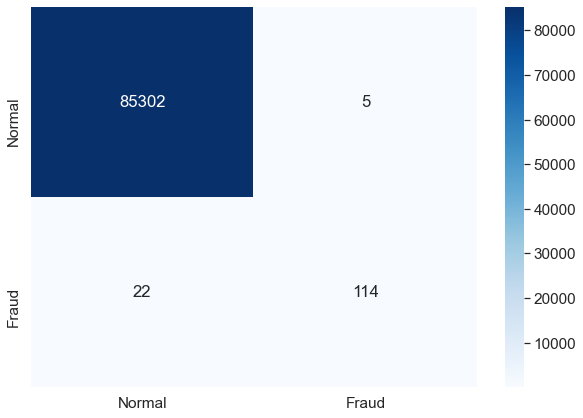

In [19]:
LABELS = ["Normal", "Fraud"]

cm = confusion_matrix(y_test, y_baseline) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, cmap="Blues", fmt="d")

print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_baseline))